# Authors

The authors of this notebook are:
- Landry SANON
- Adrien Junior TCHUEM TCHUENTE

# Objective

In this notebook, we implement the final application for the **classification** and the **localization** of lung diseases on Chest X-Rays.


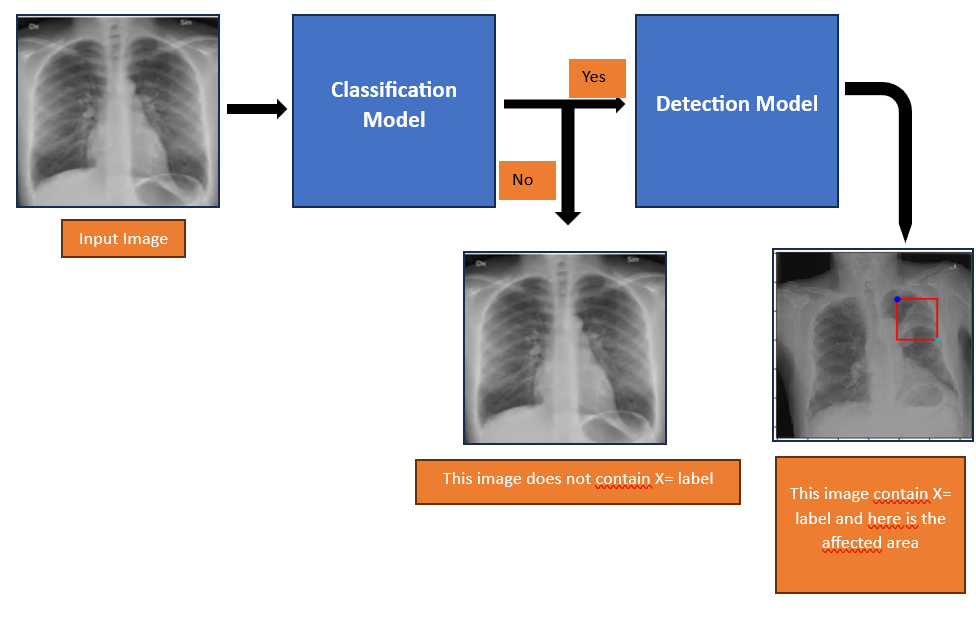

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import datetime
import os
from PIL import Image
import tensorflow as tf

from keras.models import Model
from keras.models import load_model

from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras import backend as K

import cv2
import matplotlib.pyplot as plt

import matplotlib.patches as patches
import warnings
warnings.simplefilter("ignore", UserWarning)

In [ ]:
train_data=pd.read_csv("/content/drive/MyDrive/Data/train-small.csv")
test_data=pd.read_csv("/content/drive/MyDrive/Data/test.csv")
val_data=pd.read_csv("/content/drive/MyDrive/Data/valid-small.csv")


In [ ]:
labels = list(train_data.drop(["PatientId" , "Image"],axis=1).columns)

In [ ]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=16, seed=1, target_w = 320, target_h = 320):

    print("getting train generator...")
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)


    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))

    return generator

def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=16, batch_size=64, seed=1, target_w = 320, target_h = 320):


    print("getting valid and test generators...")

    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=IMAGE_DIR,
        x_col="Image",
        y_col=labels,
        class_mode="raw",
        batch_size=sample_size,
        shuffle=True,
        target_size=(target_w, target_h))


    batch = raw_train_generator.next()
    data_sample = batch[0]


    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)

    image_generator.fit(data_sample)

    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            validate_filenames=True,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=1,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    return valid_generator, test_generator , data_sample

In [ ]:
IMAGE_DIR = "/content/drive/MyDrive/Data/images-small/"
train_generator = get_train_generator(train_data, IMAGE_DIR, "Image", labels)
val_generator, test_generator , data_sample = get_test_and_valid_generator(val_data, test_data, train_data, IMAGE_DIR, "Image", labels)

getting train generator...
Found 1000 validated image filenames.
getting valid and test generators...
Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


In [45]:
def get_mean_std_per_batch(image_path, df, H=320, W=320):

    sample_data=df
    sample_data = sample_data / 255.0
    mean = np.mean(sample_data)
    std = np.std(sample_data)
    return mean, std

def load_image(img, image_dir, df, preprocess=True, H=320, W=320):
  """Load and preprocess image."""
  img_path = image_dir + img
  mean, std = get_mean_std_per_batch(img_path, df, H=H, W=W)
  x = image.load_img(img_path, target_size=(H, W))
  x=np.asarray(x)

  if preprocess:
      x = x / 255.0
      non_normalized_x = np.copy(x)
      x -= mean
      x /= std
      #x = np.expand_dims(x, axis=0)[0]
  return x , non_normalized_x

def diagnosis(models, img, image_dir, df, labels, thresh_df=None):
    preprocessed_input, non_normalized_input = load_image(img, image_dir, df)

    Class_predictions = models[0].predict(np.array([preprocessed_input]))
    class_decision = (Class_predictions[0] >= np.asarray(thresh_df)).astype(int)

    if class_decision.sum() != 0:
        region = models[1].predict(np.array([non_normalized_input]))[0]

        x0 = region[0]
        y0 = region[1]
        h0 = region[2]
        w0 = region[3]

        # Display the original image
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        ax[0].imshow(non_normalized_input)
        ax[0].set_title('Original Image')

        # Display the image with labels found
        ax[1].imshow(non_normalized_input)
        labels_found= [labels[ind] for ind in np.where(class_decision == 1)[0]]
        labels_found = ','.join(str(x) for x in labels_found)
        text = "Labels Found " + labels_found
        ax[1].set_title(text, wrap=True)


        # Display the image with the affected region
        ax[2].imshow(non_normalized_input)

        ax[2].set_title('Affected Region')
        rect_pred = patches.Rectangle((x0, y0), w0, h0, linewidth=2, edgecolor='r', facecolor='none')
        ax[2].add_patch(rect_pred)
        ax[2].plot(x0, y0, 'o', color='b')  # top-left of the bounding box
        ax[2].plot(x0+w0, y0+h0, '*', color='c')  # bottom-right of the bounding-box
        plt.tight_layout()
        plt.show()
        fig.savefig('prediction_' + img)
    else:
        # Display the original image and an image with "No Label detected"
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

        ax[0].imshow(non_normalized_input)
        ax[0].set_title('Original Image')

        ax[1].text(0.5, 0.5, 'No Label detected', fontsize=15, ha='center', va='center', color='r')
        ax[1].axis('off')
        plt.tight_layout()
        plt.show()
        fig.savefig('prediction_' + img)



In [ ]:

img_file = '00008270_015.png' # Set the file name  00029855_001
Densenet_model_2=load_model('/content/drive/MyDrive/tmp/checkpoint/DenseNet_FT_model_weights.h5')

In [ ]:
from tensorflow.keras.applications.xception import Xception
base_model2 = Xception(include_top=False, input_shape=(320, 320, 3))

chopped_Xception = Model(inputs=[base_model2.input], outputs=[base_model2.layers[90].output])
localization_output2 = Flatten()(chopped_Xception.output)
localization_output2 = Dense(units=4, activation='relu')(localization_output2)

xception = Model(inputs=[chopped_Xception.input], outputs=localization_output2)

xception.load_weights('/content/drive/MyDrive/tmp/checkpoint/xception.h5')

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:

def get_threshold(labels, predicted_vals, true_vals):

    threshold = []
    for i in range(len(labels)):

          gt = true_vals[:, i]
          pred = predicted_vals[:, i]
          auc_roc = roc_auc_score(gt, pred)
          fpr_rf, tpr_rf, tr = roc_curve(gt, pred)
          threshold.append(tr.mean())
    print(f" Threshold : {threshold}")
    return threshold

In [ ]:
#threshold = get_threshold(labels, Densenet2_predicted_vals, val_generator.labels)
threshold = [0.22420606, 0.13594271, 0.1202877, 0.18020877, 0.3025891, 0.14911577, 0.24080105, 0.20557344, 0.287143, 0.1358277, 0.10478655, 0.12854668, 0.22114174, 0.12652722]

1/1 [==============================] - 0s 306ms/step


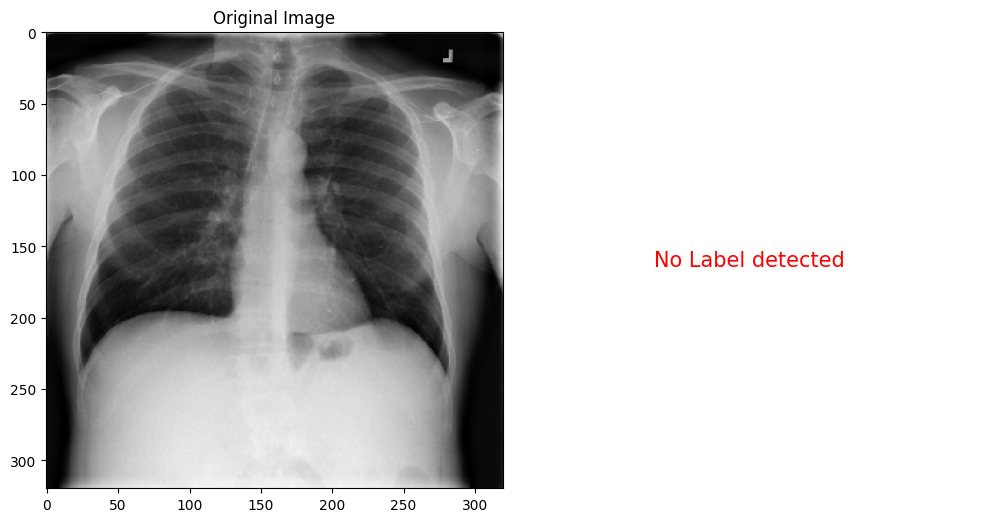

In [46]:
img_file = '00008270_015.png' # Set the file name  00029855_001
diagnosis(models=[Densenet_model_2,xception], img=img_file , image_dir= IMAGE_DIR, df= data_sample , labels=  labels , thresh_df=threshold)

1/1 [==============================] - 0s 484ms/step


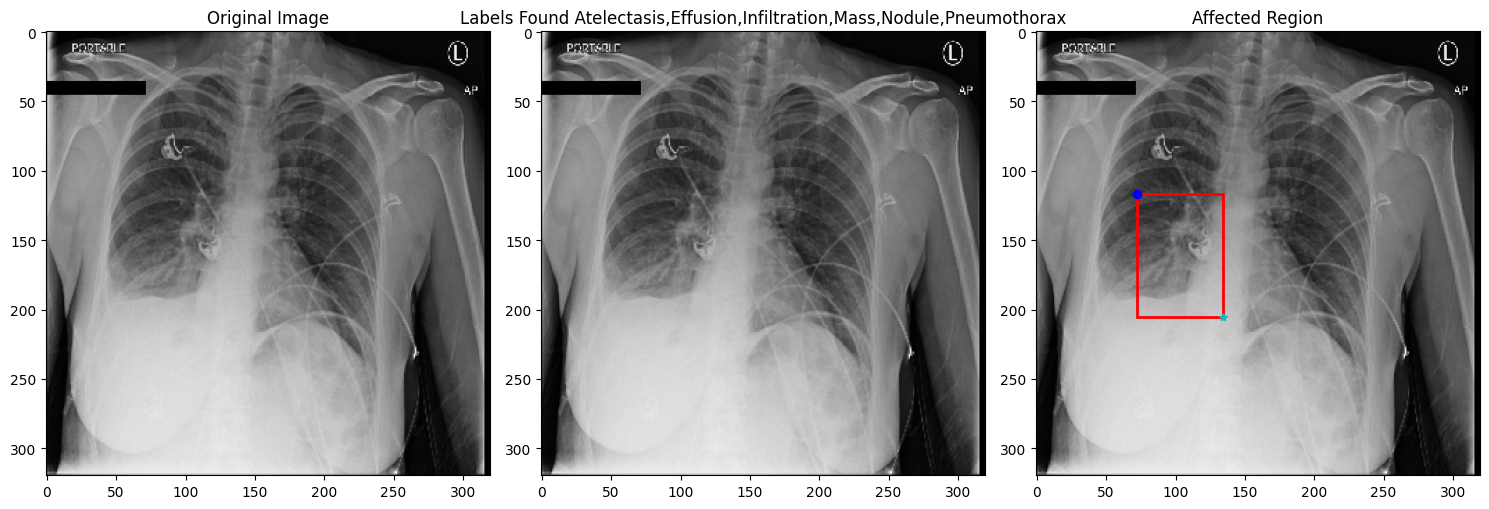

In [47]:
img_file = '00029855_001.png'
diagnosis(models=[Densenet_model_2,xception], img=img_file , image_dir= IMAGE_DIR, df= data_sample , labels=  labels , thresh_df=threshold)